In [1]:
import os
import operator
import random

import pandas as pd
import numpy as np
import tensorflow.contrib.keras as keras
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from vixstructure.utils import parse_model_repr
from vixstructure.data import LongPricesDataset

In [2]:
directory, _, files = next(os.walk("models/experiment04"))
h5_files = tuple(file for file in files if os.path.splitext(file)[1] == ".h5")
csv_files = tuple(file for file in files if os.path.splitext(file)[1] == ".csv")
stats = [(parse_model_repr(os.path.splitext(file)[0]),
          pd.read_csv(os.path.join(directory, file), header=0, index_col=0,
                      dtype={"epoch":int, "loss":np.float32, "val_loss":np.float32,
                             "denorm_mse":np.float32, "val_denorm_mse":np.float32}))
         for file in csv_files]
parameters, stats_data = zip(*stats)
for d in stats_data:
    if len(d.columns) == 2:
        use_this_as_columns = d.columns
        print(use_this_as_columns)
        break
for d in stats_data:
    if len(d.columns) == 4:
        d.drop(["loss", "val_loss"], axis=1, inplace=True)
        d.columns = use_this_as_columns
dataframe = pd.concat(stats_data, keys=[(p.depth, p.width, p.normalized) for p in parameters],
                      names=["depth", "width", "normalized"])

Index(['loss', 'val_loss'], dtype='object')


In [3]:
dataframe.sort_index(inplace=True)

In [4]:
def reduce_mean_std(dataframe):
    groups = dataframe.groupby(("depth", "width", "normalized", "epoch"))
    mean = groups.mean()
    std = groups.std()
    return pd.concat((mean, std), axis=1, keys=("mean", "std"))
dataframe_reduced = reduce_mean_std(dataframe)

In [5]:
print(dataframe_reduced.min(), dataframe_reduced.idxmin(), sep="\n")

mean  loss        0.091954
      val_loss    0.092276
std   loss        0.000497
      val_loss    0.001299
dtype: float32
mean  loss        (1, 50, False, 999)
      val_loss    (1, 50, False, 834)
std   loss         (1, 29, True, 316)
      val_loss     (1, 50, True, 110)
dtype: object


In [6]:
normal = dataframe_reduced.loc[1,:,True]
basic = dataframe_reduced.loc[1,:,False]

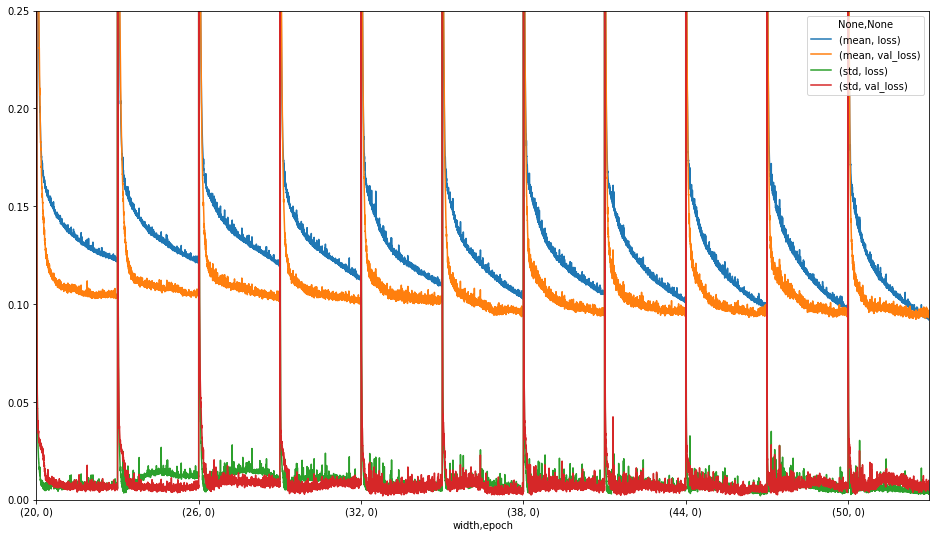

In [7]:
basic.plot(figsize=(16,9))
plt.ylim(0,0.25)
plt.show()

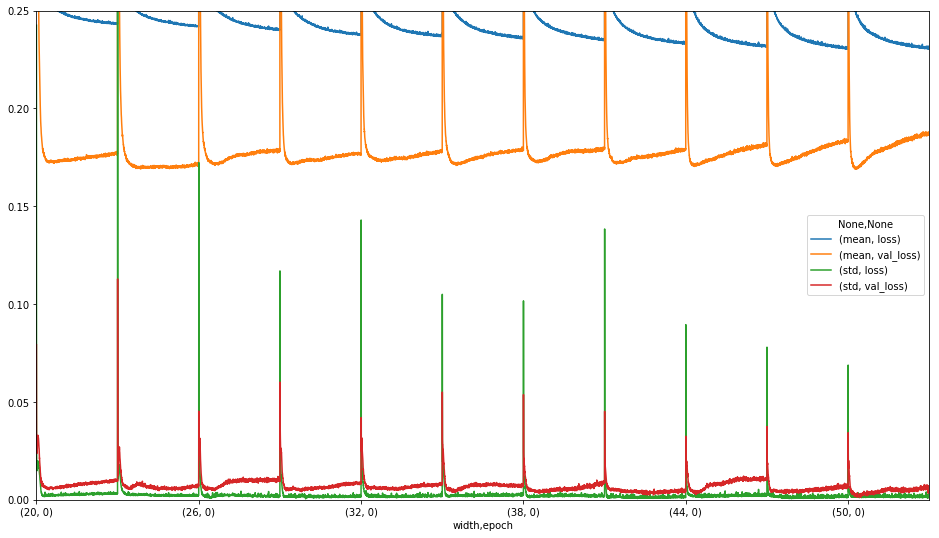

In [8]:
normal.plot(figsize=(16,9))
plt.ylim(0,0.25)
plt.show()

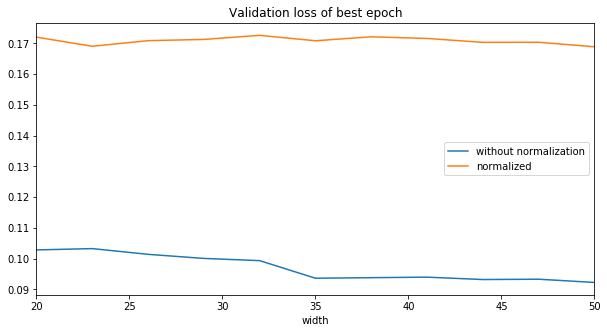

In [9]:
pd.concat((basic.groupby("width").min()["mean", "val_loss"], normal.groupby("width").min()["mean", "val_loss"]),
          axis=1, keys=("without normalization", "normalized")).plot(figsize=(10,5))
plt.title("Validation loss of best epoch")
plt.show()

In [10]:
hostnamedate = pd.concat(stats_data, keys=[(p.depth, p.width, p.normalized, p.hostname) for p in parameters],
                         names=["depth", "width", "normalized", "hostname"])
hostnamedate.sort_index(inplace=True)

In [12]:
hostnamedate.loc[1,50,False]["val_loss"].groupby("hostname").min()

hostname
tfpool02    0.084871
tfpool26    0.089658
tfpool27    0.085495
tfpool28    0.091778
tfpool60    0.087905
tfpool62    0.083676
tfpool63    0.083130
Name: val_loss, dtype: float32

In [19]:
hostnamedate.loc[1,50,False,:,999]

,loss,val_loss
hostname,,
tfpool02,0.088244,0.095291
tfpool26,0.088006,0.100991
tfpool27,0.092019,0.087615
tfpool27,0.089264,0.100555
tfpool28,0.098525,0.096907
tfpool60,0.095320,0.099694
tfpool62,0.094327,0.093405
tfpool62,0.093644,0.100369
tfpool62,0.093301,0.093560


In [21]:
print(dataframe.min(), dataframe.idxmin(), sep="\n")

loss        0.085322
val_loss    0.081293
dtype: float32
loss        (1, 50, False, 996)
val_loss    (1, 44, False, 410)
dtype: object
